In [2]:
# ==============================================================================
# PROYECTO FINAL: TOPOLOGÍA COMPUTACIONAL
# ==============================================================================
# Autoras: María Sáez Díaz y Jessica Xianping Ren
# Descripción: Implementación de complejos simpliciales, homología, 
# filtraciones (Rips/Alpha) y persistencia topológica.
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
import math
from itertools import combinations
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d  # Rips/Alpha/Voronoi

# Configuración de gráficos
plt.style.use('seaborn-v0_8-whitegrid')

print("1. Librerías cargadas correctamente.")

def smith_normal_form_z2(matrix):
    """
    Calcula el rango de una matriz sobre el cuerpo finito Z2 

    Esta función realiza una reducción por filas y columnas (eliminación gaussiana)
    para llevar la matriz a una forma diagonal (Forma Normal de Smith sobre un cuerpo).
    El número de elementos no nulos en la diagonal final corresponde al rango de la matriz.

    Este cálculo es fundamental para obtener los números de Betti:
    b_p = n_p - rank(d_p) - rank(d_{p+1})

    Parámetros:
    -----------
    matrix : np.ndarray
        Matriz de entrada (se espera que contenga 0s y 1s).
        
    Retorna:
    --------
    int
        El rango de la matriz sobre Z2.
    """

    # Si la matriz está vacía, el rango es 0
    if matrix.size == 0:
        return 0
    
    # Trabajamos sobre una copia para no alterar la matriz original
    # Aseguramos que sea de tipo entero para las operaciones módulo 2
    M = matrix.copy().astype(int)
    rows, cols = M.shape
    pivot_row = 0
    pivot_col = 0
    rank = 0

    # Algoritmo de eliminación (Reducción Gaussiana)
    while pivot_row < rows and pivot_col < cols:
        # Buscamos un pivote en la columna actual, desde la fila actual hacia abajo
        pivot_indices = np.where(M[pivot_row:, pivot_col] == 1)[0]
        if pivot_indices.size == 0:
            # No hay pivote en esta columna, pasamos a la siguiente
            pivot_col += 1
            continue

        # Si encontramos un pivote, lo movemos a la posición (pivot_row, pivot_col)
        # pivot_indices[0] es relativo al slice, sumamos pivot_row para el índice absoluto
        current_pivot_row = pivot_indices[0] + pivot_row
        if current_pivot_row != pivot_row:
            # Intercambio de filas
            M[[pivot_row, current_pivot_row]] = M[[current_pivot_row, pivot_row]]
            
        # Eliminación por filas: hacemos ceros debajo del pivote
        for i in range(pivot_row + 1, rows):
            if M[i, pivot_col] == 1:
                M[i, :] = (M[i, :] + M[pivot_row, :]) % 2

        # Eliminación por columnas: hacemos ceros a la derecha del pivote
        for j in range(pivot_col + 1, cols):
            if M[pivot_row, j] == 1:
                M[:, j] = (M[:, j] + M[:, pivot_col]) % 2

        # Avanzamos al siguiente elemento de la diagonal
        pivot_row += 1
        pivot_col += 1
        rank += 1
        
    return rank


1. Librerías cargadas correctamente.


In [3]:
class SimplicialComplex:
    """
    Clase principal para la representación y análisis de Complejos Simpliciales.

    Permite construir complejos manualmente o mediante filtraciones (Rips/Alpha),
    calcular propiedades topológicas básicas (Euler, Componentes Conexas, Estrella/Link)
    y realizar análisis de homología persistente (Números de Betti).

    Atributos:
    ----------
    _simplices : set
        Conjunto de todos los símplices (frozensets) que forman el complejo.
        Se usa un set para búsquedas O(1) y evitar duplicados.
    _simplex_values : dict
        Diccionario {simplex: valor_filtración} que almacena cuándo aparece cada símplice.
    """
    
    def __init__(self, simplices=None):
        """
        Inicializa un complejo simplicial.

        Parámetros:
        -----------
        simplices : list, opcional
            Lista de símplices para inicializar el complejo. 
            Puede ser una lista de tuplas [(0,1), (1,2)] o con valores [((0,1), 0.5)].
            Si se proporciona, se insertan automáticamente manteniendo la clausura.
        """
        self._simplices = set()
        self._simplex_values = {} # Diccionario para almacenar el valor de filtración. {simplex: float_value}

        if simplices:
            self.insert(simplices)

    # ==========================================================================
    # GESTIÓN DE DATOS Y FILTRACIÓN
    # ==========================================================================

    def add_simplex(self, simplex, value=0.0):
        """
        Añade un único símplice y asegura la propiedad de clausura (añade todas sus caras).

        Si el símplice ya existe, actualiza su valor de filtración si el nuevo valor es menor.

        Parámetros:
        -----------
        simplex : iterable
            Vértices del símplice (ej: [0, 1, 2]).
        value : float, opcional
            Valor de filtración (tiempo de nacimiento). Por defecto 0.0.
        """
        
        # Convertimos a frozenset para que sea hashable y pueda guardarse en un set
        simplex_set = frozenset(simplex)
        if not simplex_set: return

        # Para generar las caras correctamente, necesitamos una secuencia ordenada
        simplex_tuple = tuple(sorted(simplex))
        n = len(simplex_tuple)

        # Generamos todas las caras de dimensión 1 hasta n (el propio símplice)
        for r in range(1, n + 1):
            for face in combinations(simplex_tuple, r):
                face_frozen = frozenset(face)
                self._simplices.add(face_frozen)
                
                # Actualizamos el valor de filtración (nos quedamos con el nacimiento más temprano)
                if face_frozen not in self._simplex_values or value < self._simplex_values[face_frozen]:
                    self._simplex_values[face_frozen] = float(value)

    def insert(self, simplices_input, value=0.0):
        """
        Interfaz flexible para insertar múltiples símplices a la vez.

        Admite dos formatos en la lista de entrada:
        1. Solo geometría: [(0, 1), (1, 2)] -> Se usa el valor 'value' por defecto.
        2. Geometría y valor: [((0, 1), 0.5), ((1, 2), 0.8)] -> Se usa el valor específico.

        Parámetros:
        -----------
        simplices_input : list
            Lista de símplices.
        value : float, opcional
            Valor por defecto si no se especifica en la lista.
        """
        
        for item in simplices_input:
            # Detecta si es formato ((0,1), 0.5) o solo (0,1)
            # Verificamos len(item)==2 y que el primer elemento sea un iterable (símplice)
            if isinstance(item, tuple) and len(item) == 2 and isinstance(item[0], (tuple, list, np.ndarray, set)):
                self.add_simplex(item[0], item[1])
            else:
                self.add_simplex(item, value)

    # --- MÉTODOS CORREGIDOS (FUERA DE INSERT) ---

    def filtration(self, t):
        """
        Genera un subcomplejo filtrado K_t que contiene solo los símplices 
        cuyo valor de nacimiento es <= t.

        Parámetros:
        -----------
        t : float
            Umbral de filtración.

        Retorna:
        --------
        SimplicialComplex
            Un nuevo objeto SimplicialComplex con los símplices filtrados.
        """

        # Recuperamos los datos originales (tuple) para poder crear la nueva instancia
        valid_data = [(tuple(s), v) for s, v in self._simplex_values.items() if v <= t]
        return SimplicialComplex(valid_data)

    def threshold(self):
        """
        Obtiene todos los valores críticos de la filtración ordenados.

        Retorna:
        --------
        list
            Lista ordenada de floats con los tiempos de nacimiento únicos.
        """
        
        return sorted(list(set(self._simplex_values.values())))

    # ==========================================================================
    # PROPIEDADES TOPOLÓGICAS BÁSICAS
    # ==========================================================================

    @property
    def dimension(self):
        """La dimensión del complejo (la dimensión máxima de sus símplices)."""
        if not self._simplices: return -1
        # Restamos 1 porque len([v0, v1]) = 2, pero es un 1-símplice (arista)
        return max(len(f) for f in self._simplices) - 1

    def n_faces(self, n):
        """
        Devuelve todas las caras de una dimensión específica n.

        Parámetros:
        -----------
        n : int
            Dimensión deseada (0=vértices, 1=aristas, 2=triángulos...).

        Retorna:
        --------
        list
            Lista de tuplas ordenadas representando los n-símplices.
        """
        
        faces = [f for f in self._simplices if len(f) - 1 == n]
        return sorted([tuple(sorted(f)) for f in faces])

    @property
    def face_set(self):
        """
        Devuelve todas las caras del complejo, ordenadas primero por dimensión 
        y luego lexicográficamente. Útil para visualización y depuración.
        """
        return sorted([tuple(sorted(f)) for f in self._simplices], key=lambda x: (len(x), x))

    @property
    def euler_characteristic(self):
        """
        Calcula la Característica de Euler (χ).
        Fórmula: χ = Σ (-1)^k * (número de k-símplices)
        """
        return sum((-1)**(len(f)-1) for f in self._simplices)

    def star(self, simplex):
        """
        Calcula la Estrella (Star) de un símplice σ.
        Star(σ) = {τ ∈ K | σ ⊆ τ}
        Conjunto de todos los símplices que contienen a σ.
        """
        target = frozenset(simplex)
        # Devolvemos tuplas ordenadas para facilitar lectura
        return [tuple(sorted(s)) for s in self._simplices if target.issubset(s)]

    def link(self, simplex):
        """
        Calcula el Link (Enlace) de un símplice σ.
        Lk(σ) = {τ ∈ Star(σ) | τ ∩ σ = ∅}
        Es la "frontera" de la estrella.

        Retorna:
        --------
        SimplicialComplex
            Un nuevo complejo simplicial que representa el Link.
        """
        target = frozenset(simplex)
        link_faces = []
        for s in self._simplices:
            if target.issubset(s):
                # Obtenemos la cara que completa a 'target' dentro de 's'
                diff = s - target
                if diff:
                    link_faces.append(tuple(sorted(diff)))
        # Devolvemos un objeto SimplicialComplex
        return SimplicialComplex(link_faces)

    def connected_components(self):
        """
        Calcula el número de componentes conexas (Betti-0) usando Union-Find.
        Es más eficiente que calcular rangos de matrices para dimensión 0.
        """
        vertices = set(v for s in self._simplices for v in s)
        if not vertices: return 0
        
        parent = {v: v for v in vertices}

        def find(v):
            if parent[v] != v: parent[v] = find(parent[v])
            return parent[v]

        def union(u, v):
            root_u, root_v = find(u), find(v)
            if root_u != root_v: parent[root_u] = root_v

        # Unimos vértices conectados por aristas (1-símplices)
        for edge in self.n_faces(1):
            union(edge[0], edge[1])

        # El número de componentes es el número de raíces únicas
        return len({find(v) for v in vertices})

    # ==========================================================================
    # ÁLGEBRA HOMOLÓGICA (Números de Betti)
    # ==========================================================================

    def boundary_matrix(self, p):
        """
        Construye la matriz de borde ∂p (M_p) para la dimensión p.
        Mapea p-cadenas a (p-1)-cadenas.

        Parámetros:
        -----------
        p : int
            Dimensión del operador borde.

        Retorna:
        --------
        np.ndarray
            Matriz binaria (0s y 1s) donde M[i, j] = 1 si la cara i-ésima
            es frontera del símplice j-ésimo.
        """
        if p <= 0: return np.zeros((0, 0))
        
        row_faces = self.n_faces(p-1) # (p-1)-símplices (filas: destino)
        col_faces = self.n_faces(p)   # p-símplices (columnas: origen)
        
        if not col_faces: return np.zeros((0, 0))
        if not row_faces: return np.zeros((0, len(col_faces)))

        # Mapeamos cada cara (frozenset) a su índice de fila para acceso rápido
        idx_map = {frozenset(f): i for i, f in enumerate(row_faces)}
        M = np.zeros((len(row_faces), len(col_faces)), dtype=int)

        for j, sigma in enumerate(col_faces):
            sigma_set = set(sigma)
            for v in sigma: 
                # Una cara se obtiene quitando un vértice v del símplice sigma
                face = frozenset(sigma_set - {v})
                if face in idx_map:
                    M[idx_map[face], j] = 1
        return M

    def betti_numbers(self):
        """
        Calcula los Números de Betti (βp) para todas las dimensiones del complejo.
        Usa la fórmula: βp = np - rank(∂p) - rank(∂p+1)
        
        Donde:
        - np: número de p-símplices.
        - rank(∂p): rango de la matriz de borde de p a p-1.

        Retorna:
        --------
        dict
            Diccionario {dimensión: número_betti}. Ej: {0: 1, 1: 0}
        """
        dim = self.dimension
        bettis = {}
        ranks = {}

        # 1. Calcular rangos de todas las matrices borde necesarias
        # Usamos la función externa smith_normal_form_z2 para reducir la matriz
        for p in range(1, dim + 2):
            M = self.boundary_matrix(p)
            # USAMOS TU FUNCIÓN AQUÍ:
            ranks[p] = smith_normal_form_z2(M) if M.size > 0 else 0
        
        # 2. Betti 0: nº vértices - rango(M_1) (Componentes conexas)
        s0 = len(self.n_faces(0))
        bettis[0] = s0 - ranks.get(1, 0)

        # 3. Betti p > 0: s_p - rank(M_p) - rank(M_{p+1}) (Ciclos - Fronteras)
        for p in range(1, dim + 1):
            sp = len(self.n_faces(p))
            bettis[p] = sp - ranks.get(p, 0) - ranks.get(p + 1, 0)
            
        return bettis

    # ==========================================================================
    # ALGORITMO INCREMENTAL
    # ==========================================================================
    
    def incremental_algorithm(self):
        """
        Ejecuta el algoritmo incremental para calcular la evolución de los
        números de Betti conforme se añaden símplices (filtración).

        Clasifica cada símplice como:
        - Positivo (+): Crea un nuevo ciclo (aumenta Betti).
        - Negativo (-): Cierra un ciclo existente (disminuye Betti).

        Retorna:
        --------
        list
            Historial de cambios [{'val': t, 'simplex': s, 'bettis': {0:1, ...}}].
        """
        # Ordenamos todos los símplices por valor de filtración y luego por dimensión
        # Esto simula el crecimiento del complejo K_0 -> K_1 -> ... -> K_n
        ordered_simplices = sorted(
            self._simplex_values.items(), 
            key=lambda x: (x[1], len(x[0]))
        )
        
        history = []
        K_current = SimplicialComplex()
        
        print(f"{'Simplex':<20} | {'Tipo':<15} | {'Bettis'}")
        print("-" * 60)

        for simplex_set, val in ordered_simplices:
            simplex = tuple(sorted(simplex_set))
            dim = len(simplex) - 1
            
            # Calculamos Betti ANTES de insertar el nuevo símplice
            # (En una implementación optimizada esto se haría actualizando la matriz, no recalculando todo)
            betti_old = K_current.betti_numbers().get(dim, 0) if dim >=0 else 0
            if dim > 0:
                 betti_old_prev = K_current.betti_numbers().get(dim-1, 0)
            else:
                 betti_old_prev = 0

            # Insertamos el símplice en el complejo actual
            K_current.add_simplex(simplex, val)
            
            # Calculamos Betti DESPUÉS de insertar
            betti_new = K_current.betti_numbers()
            
            # Determinamos el tipo de cambio topológico
            simplex_type = ""
            if betti_new.get(dim, 0) > betti_old:
                simplex_type = "Positivo (+)" # Crea un nuevo ciclo en dimensión dim
            elif dim > 0 and betti_new.get(dim-1, 0) < betti_old_prev:
                simplex_type = "Negativo (-)" # Destruye un ciclo en dimensión dim-1 (lo rellena)
            else:
                if dim == 0: simplex_type = "Positivo (+)" # Un vértice siempre crea una componente nueva
            
            print(f"{str(simplex):<20} | {simplex_type:<15} | {betti_new}")
            history.append({'val': val, 'simplex': simplex, 'bettis': betti_new.copy()})
            
        return history

In [4]:
print("--- Ejemplo 1 ---")

#Creamos el símplice definiendo los maximales
sc_mariposa = SimplicialComplex([(0,1,2), (2,3,4)])


print("1. Dimensión:")
print(sc_mariposa.dimension)

print("\n2. Característica de Euler (V=5, A=6, C=2 -> 5-6+2 = 1):")
print(sc_mariposa.euler_characteristic)

print("\n3. Estrella del vértice central (2):")
# Debería mostrar todas las caras que tocan el 2
print(sc_mariposa.star((2,)))

print("\n4. Link del vértice central (2):")
# Debería ser la frontera opuesta: la arista (0,1) y la arista (3,4)
print(sc_mariposa.link((2,)).face_set)

--- Ejemplo 1 ---
1. Dimensión:
2

2. Característica de Euler (V=5, A=6, C=2 -> 5-6+2 = 1):
1

3. Estrella del vértice central (2):
[(2,), (2, 3, 4), (2, 3), (1, 2), (0, 1, 2), (0, 2), (2, 4)]

4. Link del vértice central (2):
[(0,), (1,), (3,), (4,), (0, 1), (3, 4)]


In [5]:
print("\n--- EJEMPLO 2 EL OCHO (1-Esqueleto) ---")
# Definimos solo las aristas (hueco)
simplices_ocho = [
    (0,1), (1,2), (0,2), # Bucle 1
    (2,3), (3,4), (2,4)  # Bucle 2
]
sc_ocho = SimplicialComplex(simplices_ocho)

print("1. Caras (Aristas y vértices):")
# Imprimimos solo aristas para no saturar
print(sorted(sc_ocho.n_faces(1)))

print("\n2. Componentes conexas:")
print(sc_ocho.connected_components())

print("\n3. Característica de Euler (V=5, A=6 -> 5-6 = -1):")
print(sc_ocho.euler_characteristic)

print("\n4. Números de Betti (Esperado {0:1, 1:2}):")
print(sc_ocho.betti_numbers())


--- EJEMPLO 2 EL OCHO (1-Esqueleto) ---
1. Caras (Aristas y vértices):
[(0, 1), (0, 2), (1, 2), (2, 3), (2, 4), (3, 4)]

2. Componentes conexas:
1

3. Característica de Euler (V=5, A=6 -> 5-6 = -1):
-1

4. Números de Betti (Esperado {0:1, 1:2}):
{0: 1, 1: 2}


In [6]:
print("\n--- EJEMPLO 3: SISTEMA DESCONECTADO ---")
# Un tetraedro sólido y una arista lejos
sc_disjoint = SimplicialComplex([(0,1,2,3), (5,6)])

print("1. Conjunto de 3-símplices:")
print(sc_disjoint.n_faces(3))

print("\n2. Conjunto de 1-símplices (Aristas):")
# Notar que el tetraedro genera muchas aristas, y (5,6) está aparte
print(sorted(sc_disjoint.n_faces(1)))

print("\n3. Número de componentes conexas (Esperado: 2):")
print(sc_disjoint.connected_components())

print("\n4. Estrella del vértice aislado (5):")
print(sc_disjoint.star((5,)))


--- EJEMPLO 3: SISTEMA DESCONECTADO ---
1. Conjunto de 3-símplices:
[(0, 1, 2, 3)]

2. Conjunto de 1-símplices (Aristas):
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (5, 6)]

3. Número de componentes conexas (Esperado: 2):
2

4. Estrella del vértice aislado (5):
[(5, 6), (5,)]


In [7]:
print("--- EJEMPLO 4: PIRÁMIDE (Filtración por Etapas) ---")
sc_pyr = SimplicialComplex()

# t=1.0: Vértices (0,1,2 base, 3 cúspide)
sc_pyr.insert([((0,), 1.0), ((1,), 1.0), ((2,), 1.0), ((3,), 1.0)])

# t=2.0: Aristas de la base (Triángulo hueco)
sc_pyr.insert([((0,1), 2.0), ((1,2), 2.0), ((0,2), 2.0)])

# t=3.0: Aristas laterales (Conectan la base con la cúspide)
sc_pyr.insert([((0,3), 3.0), ((1,3), 3.0), ((2,3), 3.0)])

# t=4.0: Caras (Rellenan la superficie, dejando el interior vacío)
# Nota: No añadimos el tetraedro sólido (0,1,2,3), solo las caras externas.
sc_pyr.insert([((0,1,2), 4.0), ((0,1,3), 4.0), ((1,2,3), 4.0), ((0,2,3), 4.0)])

# Analizamos la evolución
etapas = {
    1.0: "Vértices",
    2.0: "Base Hueca",
    3.0: "Esqueleto Alambre",
    4.0: "Superficie Cerrada"
}

for t, desc in etapas.items():
    k_t = sc_pyr.filtration(t)
    print(f"\nTiempo t={t} ({desc}):")
    print(f"  Caras: {sorted(list(k_t.face_set), key=lambda x: (len(x), x))}")
    bettis = k_t.betti_numbers()
    desc_betti = ""
    if t == 1.0: desc_betti = "-> 4 componentes desconectadas"
    elif t == 2.0: desc_betti = "-> 1 ciclo (base) y el vértice 3 suelto"
    elif t == 3.0: desc_betti = "-> Estructura conectada con múltiples ciclos"
    elif t == 4.0: desc_betti = "-> ¡Nace una cavidad (void) en dim 2!"
    
    print(f"  Betti: {bettis} {desc_betti}")

print("\nOrden de Filtración:")
print(sorted(sc_pyr._simplex_values.items(), key=lambda x: (x[1], len(x[0]), x[0])))

--- EJEMPLO 4: PIRÁMIDE (Filtración por Etapas) ---

Tiempo t=1.0 (Vértices):
  Caras: [(0,), (1,), (2,), (3,)]
  Betti: {0: 4} -> 4 componentes desconectadas

Tiempo t=2.0 (Base Hueca):
  Caras: [(0,), (1,), (2,), (3,), (0, 1), (0, 2), (1, 2)]
  Betti: {0: 2, 1: 1} -> 1 ciclo (base) y el vértice 3 suelto

Tiempo t=3.0 (Esqueleto Alambre):
  Caras: [(0,), (1,), (2,), (3,), (0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
  Betti: {0: 1, 1: 3} -> Estructura conectada con múltiples ciclos

Tiempo t=4.0 (Superficie Cerrada):
  Caras: [(0,), (1,), (2,), (3,), (0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]
  Betti: {0: 1, 1: 0, 2: 1} -> ¡Nace una cavidad (void) en dim 2!

Orden de Filtración:
[(frozenset({0}), 1.0), (frozenset({1}), 1.0), (frozenset({2}), 1.0), (frozenset({3}), 1.0), (frozenset({0, 1}), 2.0), (frozenset({1, 2}), 2.0), (frozenset({0, 2}), 2.0), (frozenset({0, 3}), 3.0), (frozenset({1, 3}), 3.0), (frozenset({2, 3}), 3.0), (frozenset

In [8]:
def vietoris_rips_filtration(points, max_epsilon, max_dim=2):
    """
    Construye filtración Vietoris-Rips manualmente (distancias + cliques).
    """
    num_points = len(points)
    simplices = [] 
    
    # 1. Vértices
    for i in range(num_points):
        simplices.append(((i,), 0.0))
        
    # 2. Aristas
    edges = []
    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = math.sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(points[i], points[j])))
            if dist <= max_epsilon:
                edge = tuple(sorted((i, j)))
                simplices.append((edge, dist))
                edges.append((edge, dist))

    # 3. Triángulos
    if max_dim >= 2:
        edge_dict = {e[0]: e[1] for e in edges}
        for i in range(num_points):
            for j in range(i + 1, num_points):
                for k in range(j + 1, num_points):
                    if (i, j) in edge_dict and (j, k) in edge_dict and (i, k) in edge_dict:
                        birth = max(edge_dict[(i, j)], edge_dict[(j, k)], edge_dict[(i, k)])
                        if birth <= max_epsilon:
                            simplices.append(((i, j, k), birth))

    sc = SimplicialComplex()
    sc.insert(simplices)
    return sc

def alpha_complex_filtration(points):
    """
    Calcula filtración de Alfa Complejos usando Delaunay.
    """
    points = np.array(points)
    tri = Delaunay(points)
    complex_data = []

    def circumradius(simp_indices):
        pts = points[list(simp_indices)]
        if len(pts) == 2:
            return np.linalg.norm(pts[0] - pts[1]) / 2.0
        elif len(pts) == 3:
            a, b, c = pts[0], pts[1], pts[2]
            la, lb, lc = np.linalg.norm(b - c), np.linalg.norm(a - c), np.linalg.norm(a - b)
            p = (la + lb + lc) / 2
            area_term = p * (p - la) * (p - lb) * (p - lc)
            area = np.sqrt(area_term) if area_term > 0 else 0
            return (la * lb * lc) / (4 * area) if area > 0 else float('inf')
        return 0.0

    # Vértices
    for i in range(len(points)):
        complex_data.append(((i,), 0.0))

    # Triángulos y aristas de Delaunay
    for simplex in tri.simplices:
        complex_data.append((tuple(sorted(simplex)), circumradius(simplex)))
        for i in range(3):
            edge = tuple(sorted([simplex[i], simplex[(i + 1) % 3]]))
            complex_data.append((edge, circumradius(edge)))
            
    sc = SimplicialComplex()
    sc.insert(complex_data)
    return sc

print("3. Funciones de filtración (Rips y Alpha) cargadas.")


3. Funciones de filtración (Rips y Alpha) cargadas.


In [17]:
def compute_persistence_matrix(complex_obj):
    """
    Calcula intervalos de persistencia usando Reducción de Matriz Borde.
    Retorna: {dimensión: [(nacimiento, muerte), ...]}.
    """
    # 1. Ordenamos la filtración (por valor y luego por dimensión)
    filtration = sorted(
        complex_obj._simplex_values.items(),
        key=lambda x: (x[1], len(x[0]))
    )
    n = len(filtration)
    
    # Mapeos índice <-> símplice
    idx_to_simplex = {i: s for i, s in enumerate(filtration)}
    simplex_to_idx = {s[0]: i for i, s in enumerate(filtration)}
    
    # 2. Construir Matriz Borde (dispersa)
    columns = {}
    for j in range(n):
        simp, val = idx_to_simplex[j]
        dim = len(simp) - 1
        col = set()
        
        # Las caras tienen dimensión dim-1. 
        # Combinations devuelve tuplas, pero el diccionario usa frozensets.
        if dim > 0:
            for face in combinations(simp, dim): # dim aquí es len(face) deseada
                face_key = frozenset(face)       # <--- CORRECCIÓN CLAVE
                if face_key in simplex_to_idx:
                    col.add(simplex_to_idx[face_key])
        columns[j] = col

    # 3. Reducción Gaussiana Z2 (Algoritmo Estándar)
    pivot_to_col = {} 
    for j in range(n):
        while columns[j]:
            low_j = max(columns[j]) # Pivote: fila más baja (índice mayor)
            if low_j in pivot_to_col:
                k = pivot_to_col[low_j]
                columns[j] = columns[j].symmetric_difference(columns[k])
            else:
                pivot_to_col[low_j] = j
                break
                
    # 4. Extraer diagrama
    diagram = {}
    deaths = set(pivot_to_col.values())          # Columnas que matan (negativos)
    births_with_death = set(pivot_to_col.keys()) # Filas que mueren (positivos emparejados)
    
    # A) Intervalos finitos [nacimiento, muerte)
    for i, j in pivot_to_col.items():
        birth = idx_to_simplex[i][1]
        death = idx_to_simplex[j][1]
        dim = len(idx_to_simplex[i][0]) - 1
        
        # Guardamos solo si hay persistencia real
        if death > birth:
            diagram.setdefault(dim, []).append((birth, death))
        
    # B) Intervalos infinitos [nacimiento, inf)
    for i in range(n):
        # Si no murió y no es un "asesino" (es decir, columna vacía al final)
        if i not in births_with_death and i not in deaths:
            birth = idx_to_simplex[i][1]
            dim = len(idx_to_simplex[i][0]) - 1
            diagram.setdefault(dim, []).append((birth, float('inf')))
            
    return diagram

print("4. Algoritmo de Persistencia (Matriz) CORREGIDO cargado.")

4. Algoritmo de Persistencia (Matriz) CORREGIDO cargado.


In [18]:
def plot_barcode(diagram, title="Código de Barras"):
    fig, ax = plt.subplots(figsize=(10, 4))
    y = 0
    colors = {0: 'blue', 1: 'red'}
    valid_dims = [d for d in diagram.keys() if d < 2]  # Solo H0 y H1
    
    all_vals = [d for dim in valid_dims for b, d in diagram[dim] if d != float('inf')]
    max_val = max(all_vals) if all_vals else 1.0
    inf_limit = max_val * 1.2

    for dim in sorted(valid_dims):
        bars = sorted(
            diagram[dim],
            key=lambda x: (x[1] if x[1] != float('inf') else 999) - x[0],
            reverse=True
        )
        for b, d in bars:
            end = d if d != float('inf') else inf_limit
            ax.plot([b, end], [y, y], color=colors.get(dim, 'k'), lw=3)
            if d == float('inf'):
                ax.text(end, y, r' $\infty$', va='center')
            y += 1
        y += 2
        
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xlabel("Filtración")
    plt.show()

def plot_persistence_diagram(diagram, title="Diagrama de Persistencia"):
    fig, ax = plt.subplots(figsize=(5, 5))
    valid_dims = [d for d in diagram.keys() if d < 2]
    all_vals = [d for dim in valid_dims for b, d in diagram[dim] if d != float('inf')]
    max_val = max(all_vals) if all_vals else 1.0
    inf_limit = max_val * 1.1
    
    ax.plot([0, inf_limit], [0, inf_limit], 'k--', alpha=0.5)
    colors = {0: 'blue', 1: 'red'}
    
    for dim in sorted(valid_dims):
        pairs = diagram[dim]
        births = [p[0] for p in pairs]
        deaths = [p[1] if p[1] != float('inf') else inf_limit for p in pairs]
        ax.scatter(births, deaths, color=colors.get(dim, 'k'), label=f'H{dim}', alpha=0.6)
        
    ax.set_title(title)
    ax.set_xlabel("Nacimiento")
    ax.set_ylabel("Muerte")
    ax.legend()
    plt.show()

def visualize_incremental_step(ax, simplices_so_far, new_simplex, points, title):
    for simplex in simplices_so_far:
        if simplex == new_simplex:
            continue
        pts = points[list(simplex)]
        if len(simplex) == 1:
            ax.plot(pts[0][0], pts[0][1], 'bo', markersize=6, alpha=0.3)
        elif len(simplex) == 2:
            ax.plot(pts[:, 0], pts[:, 1], 'b-', alpha=0.2)
        elif len(simplex) == 3:
            ax.fill(pts[:, 0], pts[:, 1], 'cyan', alpha=0.1)

    pts_new = points[list(new_simplex)]
    if len(new_simplex) == 1:
        ax.plot(pts_new[0][0], pts_new[0][1], 'ro', markersize=10)
    elif len(new_simplex) == 2:
        ax.plot(pts_new[:, 0], pts_new[:, 1], 'r-', linewidth=2.5)
    elif len(new_simplex) == 3:
        ax.fill(pts_new[:, 0], pts_new[:, 1], 'red', alpha=0.4)
    ax.set_title(title, fontsize=9)
    ax.axis('off')

def run_visual_incremental(sc, points):
    ordered = sorted(sc._simplex_values.items(), key=lambda x: (x[1], len(x[0])))
    n = min(len(ordered), 16)
    cols = 4
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    axes = axes.flatten()
    K_curr = SimplicialComplex()
    hist = []
    
    print("\n--- Visualización Algoritmo Incremental ---")
    for i in range(n):
        simplex, val = ordered[i]
        K_curr.add_simplex(simplex, val)
        hist.append(simplex)
        bettis = K_curr.betti_numbers()
        if i < len(axes):
            visualize_incremental_step(
                axes[i], hist, simplex, points,
                f"Paso {i+1}: {simplex}\nB: {bettis}"
            )
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

print("5. Visualización cargada.")


5. Visualización cargada.


In [19]:
def get_torus_minimal():
    return [
        (0,1,2),(0,1,5),(0,2,4),(0,3,4),(0,3,6),(0,5,6),
        (1,2,6),(1,3,4),(1,3,5),(1,4,6),(2,3,5),(2,3,6),
        (2,4,5),(3,4,6),(4,5,6)
    ]

def get_klein_bottle():
    return [
        (0,1,4),(1,2,5),(2,0,3),(0,4,3),(1,5,4),(2,3,5),
        (3,4,7),(4,5,8),(5,3,6),(3,7,6),(4,8,7),(5,6,8),
        (6,7,2),(7,8,0),(8,6,1),(6,2,5),(7,0,3),(8,1,4)
    ]

def get_projective_plane():
    return [tuple(v - 1 for v in s) for s in [
        (1,2,6),(1,2,5),(1,3,4),(1,3,6),(1,4,5),(2,3,5),
        (2,3,6),(2,4,5),(2,4,6),(3,4,6),(3,4,5),(3,5,6),
        (4,5,6),(1,2,3),(1,2,4),(1,3,5),(1,4,6),(1,5,6),
        (2,3,4),(2,5,6)
    ]]

def get_dunce_hat():
    return [(0,1,2), (0,1,3), (0,2,3), (1,2,3)]

def get_tetrahedron():
    return [(0,1,2,3)]

def get_transparency_4_complex():
    return [(0,1,2),(1,2,3),(2,3,0)]

print("6. Generadores de superficies listos.")


6. Generadores de superficies listos.


=== 1. NÚMEROS DE BETTI DE SUPERFICIES ===
  > Tetraedro            | Betti: {0: 1, 1: 0, 2: 0, 3: 0}
  > Toro (7 vért.)       | Betti: {0: 1, 1: 1, 2: 1}
  > Botella Klein        | Betti: {0: 1, 1: 1, 2: 0}
  > Plano Proyectivo     | Betti: {0: 1, 1: 0, 2: 10}
  > Sombrero Asno        | Betti: {0: 1, 1: 0, 2: 1}
  > Transparencia 4      | Betti: {0: 1, 1: 0, 2: 0}

=== 2. PERSISTENCIA: NUBE DE PUNTOS ===
  > Rips...


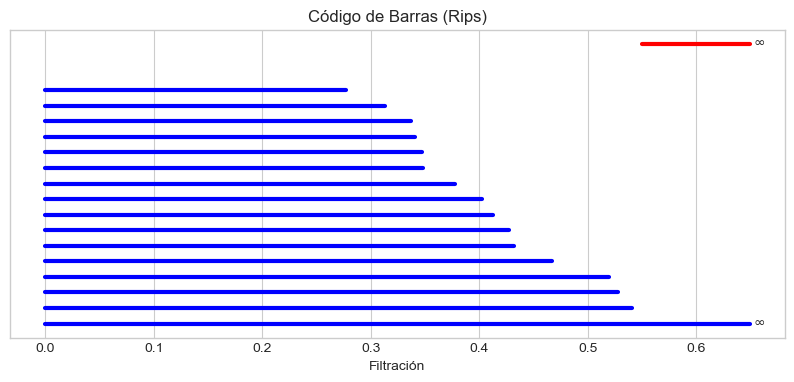

  > Alfa...


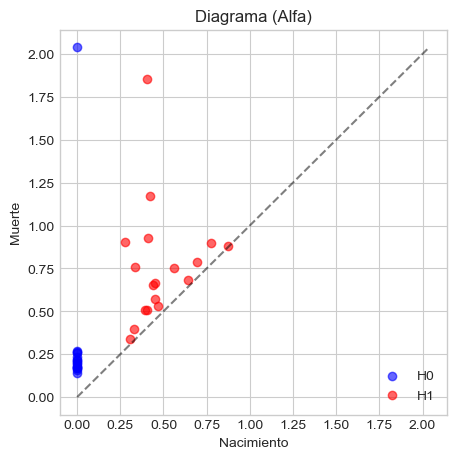


=== 3. VISUALIZACIÓN INCREMENTAL ===

--- Visualización Algoritmo Incremental ---


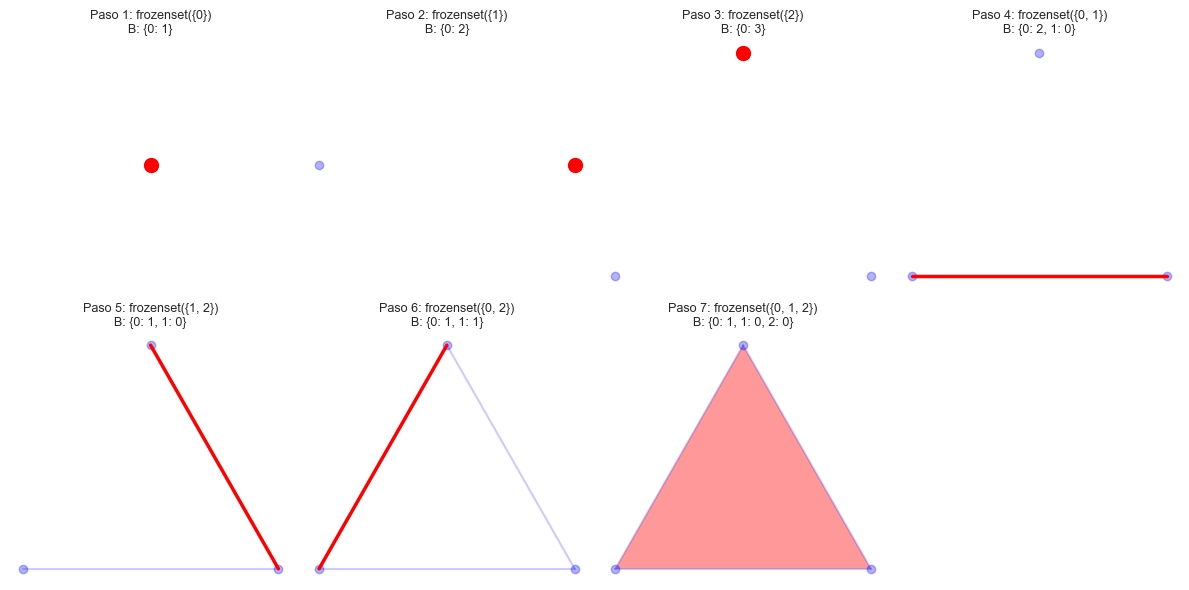

In [20]:
# ==============================================================================
# EJECUCIÓN Y VALIDACIÓN
# ==============================================================================

print("=== 1. NÚMEROS DE BETTI DE SUPERFICIES ===")
surfaces = {
    "Tetraedro": get_tetrahedron(),
    "Toro (7 vért.)": get_torus_minimal(),
    "Botella Klein": get_klein_bottle(),
    "Plano Proyectivo": get_projective_plane(),
    "Sombrero Asno": get_dunce_hat(),
    "Transparencia 4": get_transparency_4_complex()
}

for name, data in surfaces.items():
    sc = SimplicialComplex()
    sc.insert(data)
    print(f"  > {name:<20} | Betti: {sc.betti_numbers()}")

print("\n=== 2. PERSISTENCIA: NUBE DE PUNTOS ===")
np.random.seed(42)
t = np.linspace(0, 2 * np.pi, 16, endpoint=False)
points = np.column_stack([np.cos(t), np.sin(t)]) + np.random.normal(0, 0.08, (16, 2))

print("  > Rips...")
sc_rips = vietoris_rips_filtration(points, 1.5, 2)
diag_rips = compute_persistence_matrix(sc_rips)
plot_barcode(diag_rips, "Código de Barras (Rips)")

print("  > Alfa...")
sc_alpha = alpha_complex_filtration(points)
diag_alpha = compute_persistence_matrix(sc_alpha)
plot_persistence_diagram(diag_alpha, "Diagrama (Alfa)")

print("\n=== 3. VISUALIZACIÓN INCREMENTAL ===")
tri_points = np.array([[0.1, 0.1], [0.9, 0.1], [0.5, 0.8]])
sc_demo = SimplicialComplex()
sc_demo.insert([
    ((0,), 1), ((1,), 2), ((2,), 3),
    ((0,1), 4), ((1,2), 5), ((0,2), 6),
    ((0,1,2), 7)
])
run_visual_incremental(sc_demo, tri_points)


=== PRUEBA VISUAL: VORONOI Y ALFA ===
1. Generando Diagrama de Voronoi...


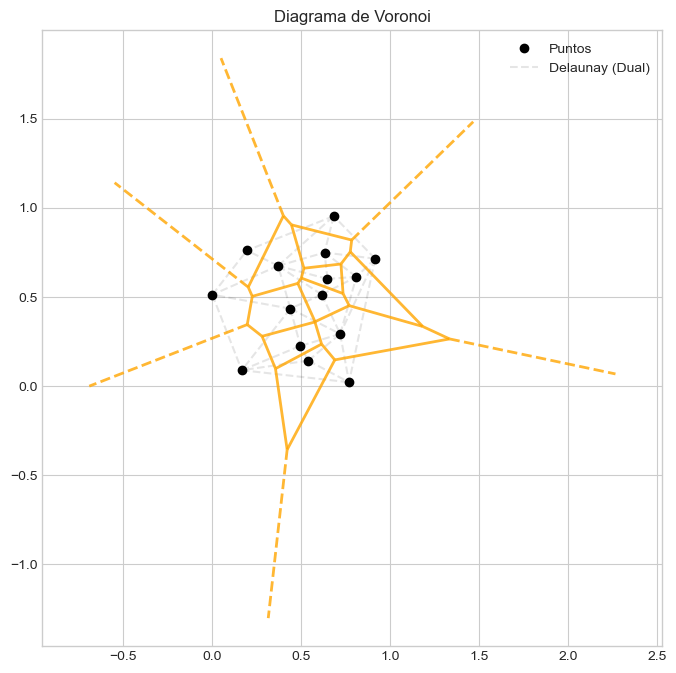

2. Generando Alfa Complejo (alpha=0.15 - Poca conectividad)...


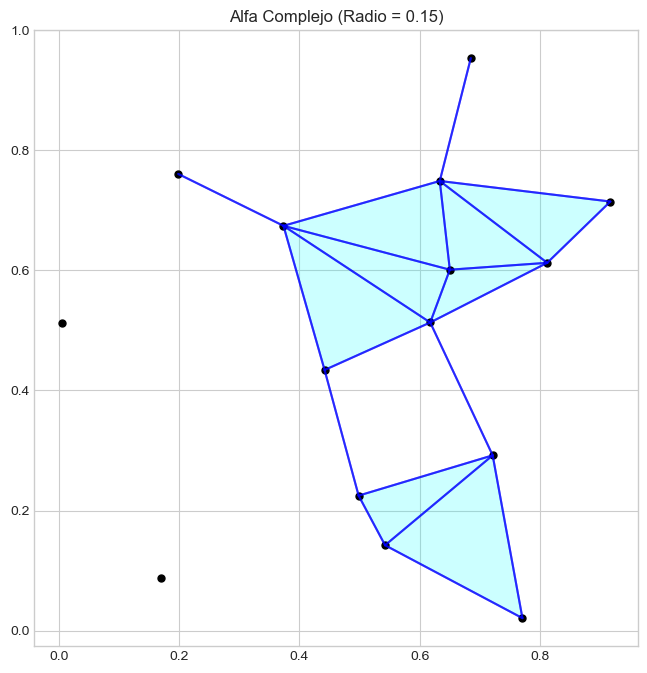

3. Generando Alfa Complejo (alpha=0.3 - Aparecen ciclos)...


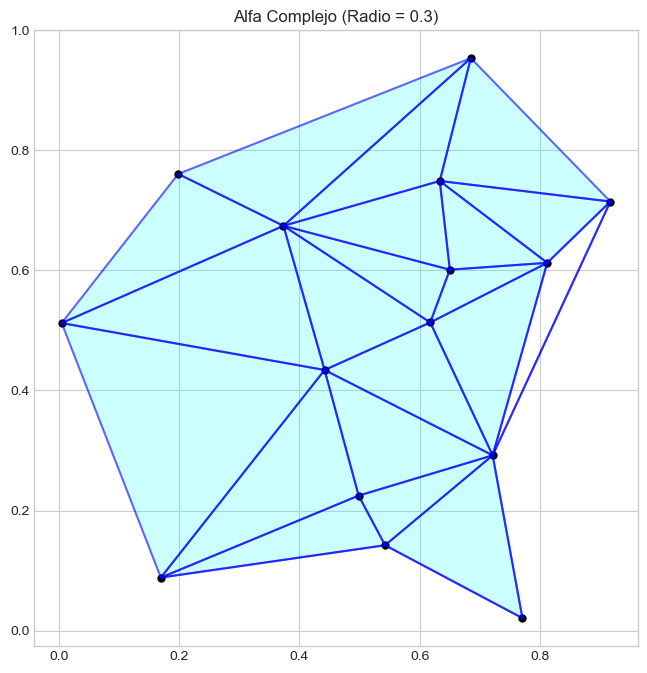

In [21]:
# ==============================================================================
# SECCIÓN 7: VISUALIZACIÓN GEOMÉTRICA (VORONOI Y ALFA)
# ==============================================================================

def plot_voronoi_diagram(points, title="Diagrama de Voronoi"):
    """
    Dibuja el Diagrama de Voronoi y la Triangulación de Delaunay (en gris suave).
    """
    vor = Voronoi(points)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    voronoi_plot_2d(
        vor, ax=ax, show_vertices=False, line_colors='orange', 
        line_width=2, line_alpha=0.8, point_size=2
    )
    
    ax.plot(points[:, 0], points[:, 1], 'ko', markersize=6, label='Puntos')
    
    tri = Delaunay(points)
    ax.triplot(points[:, 0], points[:, 1], tri.simplices, 'k--', alpha=0.1, label='Delaunay (Dual)')
    
    ax.set_title(title)
    ax.legend()
    margin = 0.5
    ax.set_xlim(np.min(points[:, 0]) - margin, np.max(points[:, 0]) + margin)
    ax.set_ylim(np.min(points[:, 1]) - margin, np.max(points[:, 1]) + margin)
    plt.axis('equal')
    plt.show()

def plot_alpha_complex_at_alpha(points, alpha, title=None):
    """
    Dibuja el Alfa Complejo para un valor concreto de alpha (radio).
    Muestra los triángulos y aristas de Delaunay que tienen radio < alpha.
    """
    tri = Delaunay(points)
    
    def get_radius(simp_indices):
        pts = points[list(simp_indices)]
        if len(pts) == 2:
            return np.linalg.norm(pts[0] - pts[1]) / 2.0
        elif len(pts) == 3:
            a, b, c = pts[0], pts[1], pts[2]
            la, lb, lc = np.linalg.norm(b - c), np.linalg.norm(a - c), np.linalg.norm(a - b)
            p = (la + lb + lc) / 2
            area_term = p * (p - la) * (p - lb) * (p - lc)
            area = np.sqrt(area_term) if area_term > 0 else 0
            return (la * lb * lc) / (4 * area) if area > 0 else float('inf')
        return 0.0

    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.plot(points[:, 0], points[:, 1], 'ko', markersize=5)
    
    for simplex in tri.simplices:
        if get_radius(simplex) <= alpha:
            pts = points[list(simplex)]
            ax.fill(pts[:, 0], pts[:, 1], 'cyan', alpha=0.2)
        for i in range(3):
            edge_idx = [simplex[i], simplex[(i + 1) % 3]]
            if get_radius(edge_idx) <= alpha:
                pts = points[edge_idx]
                ax.plot(pts[:, 0], pts[:, 1], 'b-', alpha=0.6)
    
    ax.set_title(title or f"Alfa Complejo (Radio = {alpha})")
    ax.set_aspect('equal')
    plt.show()

# --- EJECUCIÓN DE PRUEBA DE VISUALIZACIÓN ---
print("=== PRUEBA VISUAL: VORONOI Y ALFA ===")

np.random.seed(10)
random_points = np.random.rand(15, 2)

print("1. Generando Diagrama de Voronoi...")
plot_voronoi_diagram(random_points)

print("2. Generando Alfa Complejo (alpha=0.15 - Poca conectividad)...")
plot_alpha_complex_at_alpha(random_points, alpha=0.15)

print("3. Generando Alfa Complejo (alpha=0.3 - Aparecen ciclos)...")
plot_alpha_complex_at_alpha(random_points, alpha=0.3)


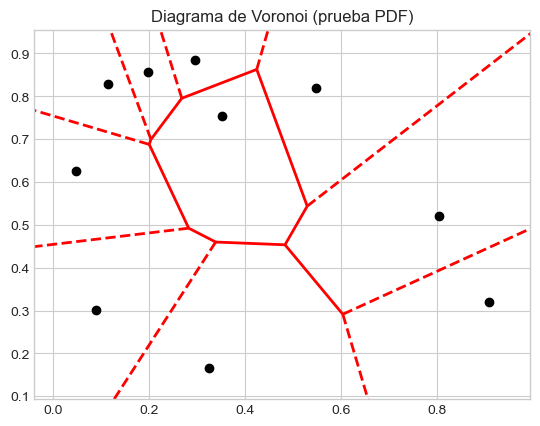

Símplices maximales de Delaunay (Del.simplices):
[[2 7 4]
 [7 2 9]
 [0 9 1]
 [0 7 9]
 [7 0 5]
 [7 3 4]
 [8 7 5]
 [6 3 7]
 [8 6 7]]


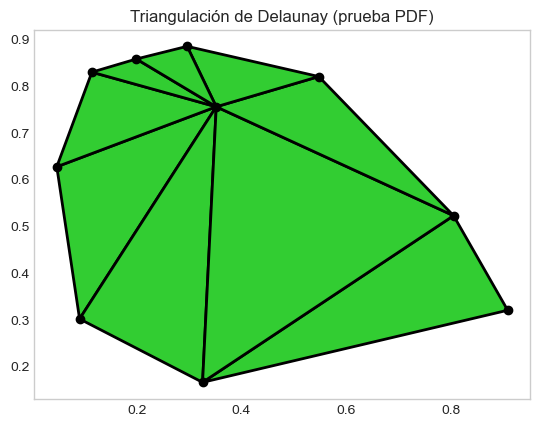

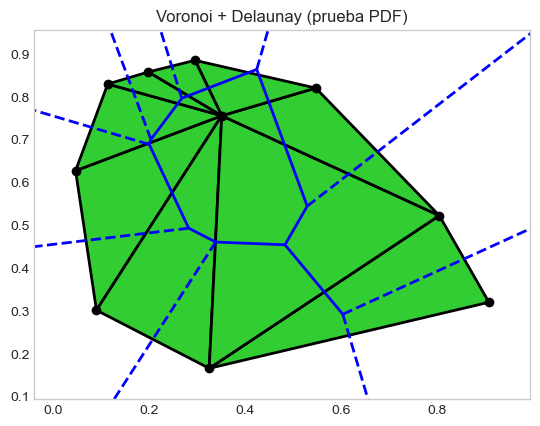

In [22]:
# ============================================================================
# PRUEBAS DEL PDF "Voronoi y Delaunay"
# ============================================================================

import matplotlib.colors
import matplotlib as mpl

# 1) Generar aleatoriamente 10 puntos en el plano
points = np.random.rand(10, 2)

# 2) Calcular diagrama de Voronoi y representarlo
vor = Voronoi(points)

fig = voronoi_plot_2d(
    vor,
    show_vertices=False,
    line_width=2,
    line_colors='red'
)
plt.plot(points[:, 0], points[:, 1], 'ko')
plt.title("Diagrama de Voronoi (prueba PDF)")
plt.show()

# 3) Calcular triangulación de Delaunay
Del = Delaunay(points)

print("Símplices maximales de Delaunay (Del.simplices):")
print(Del.simplices)

# 4) Representar gráficamente la triangulación de Delaunay
c = np.ones(len(points))
cmap = matplotlib.colors.ListedColormap(["limegreen"])

plt.tripcolor(
    points[:, 0], points[:, 1],
    Del.simplices,
    c,
    edgecolor="k",
    lw=2,
    cmap=cmap
)
plt.plot(points[:, 0], points[:, 1], 'ko')
plt.title("Triangulación de Delaunay (prueba PDF)")
plt.show()

# 5) Representar Delaunay sobre Voronoi
fig = voronoi_plot_2d(
    vor,
    show_vertices=False,
    line_width=2,
    line_colors='blue'
)

c = np.ones(len(points))
cmap = matplotlib.colors.ListedColormap(["limegreen"])

plt.tripcolor(
    points[:, 0], points[:, 1],
    Del.simplices,
    c,
    edgecolor="k",
    lw=2,
    cmap=cmap
)
plt.plot(points[:, 0], points[:, 1], 'ko')
plt.title("Voronoi + Delaunay (prueba PDF)")
plt.show()



In [23]:
# ==============================================================================
# PARTE 1: REPLICACIÓN DE EJEMPLOS DEL PDF "EJEMPLOS HOMOLOGÍA"
# ==============================================================================

def print_example_results(name, sc):
    print(f"\n--- {name} ---")
    print(f"Dimensión del complejo: {sc.dimension}")
    print(f"Números de Betti: {sc.betti_numbers()}")
    print(f"Car. Euler: {sc.euler_characteristic}")

# ---------------------------------------------------------
# Ejemplo 1: 3-Símplice sólido (Tetraedro relleno)
# ---------------------------------------------------------
sc1 = SimplicialComplex([(0, 1, 2, 3)])
print_example_results("Ejemplo 1: 3-Símplice (Sólido)", sc1)

# ---------------------------------------------------------
# Ejemplo 2: Borde del tetraedro (Esfera S2 hueca)
# ---------------------------------------------------------
# Tomamos todas las caras de dimensión 2 del ejemplo anterior
sc2 = SimplicialComplex(sc1.n_faces(2))
print_example_results("Ejemplo 2: Borde del Tetraedro (S2)", sc2)

# ---------------------------------------------------------
# Ejemplo 3: Complejo mixto
# Símplices maximales: (0,1), (1,2,3,4), (4,5), (5,6), (4,6), (6,7,8), (8,9)
# Nota: (1,2,3,4) es un 3-símplice.
# ---------------------------------------------------------
sc3 = SimplicialComplex([
    (0,1), 
    (1,2,3,4), 
    (4,5), (5,6), (4,6), 
    (6,7,8), 
    (8,9)
    ])
print_example_results("Ejemplo 3: Complejo Mixto", sc3)

# ---------------------------------------------------------
# Ejemplo 4: 1-Esqueleto del Ejemplo 3
# Solo las aristas del complejo anterior
# ---------------------------------------------------------
sc4 = SimplicialComplex(sc3.n_faces(1))
print_example_results("Ejemplo 4: 1-Esqueleto del Ej. 3", sc4)

# ---------------------------------------------------------
# Ejemplo 5: Triángulo relleno + aristas
# Símplices maximales: (0,1,2), (2,3), (3,4)
# ---------------------------------------------------------
sc5 = SimplicialComplex([(0,1,2), (2,3), (3,4)])
print_example_results("Ejemplo 5", sc5)

# ---------------------------------------------------------
# Ejemplo 6: Triangulación del anillo cerrado (Annulus)
# ---------------------------------------------------------
sc6 = SimplicialComplex([
    (1,2,4), (1,3,6), (1,4,6), 
    (2,3,5), (2,4,5), (3,5,6)
])
print_example_results("Ejemplo 6: Anillo Cerrado", sc6)

# ---------------------------------------------------------
# Ejemplo 7: 1-Esqueleto del anillo
# ---------------------------------------------------------
sc7 = SimplicialComplex(sc6.n_faces(1))
print_example_results("Ejemplo 7: 1-Esqueleto del Anillo", sc7)

# ---------------------------------------------------------
# Ejemplo 8: El Toro (Triangulación)
# ---------------------------------------------------------
sc8 = SimplicialComplex([
    (1,2,4), (2,4,5), (2,3,5), (3,5,6), (1,3,6), (1,4,6),
    (4,5,7), (5,7,8), (5,6,8), (6,8,9), (4,6,9), (4,7,9),
    (1,7,8), (1,2,8), (2,8,9), (2,3,9), (3,7,9), (1,3,7)
])
print_example_results("Ejemplo 8: El Toro", sc8)

# ---------------------------------------------------------
# Ejemplo 9: Plano Proyectivo Real (RP2)
# Nota: En homología Z2, los Betti numbers deberían ser {0:1, 1:1, 2:1}
# ---------------------------------------------------------
sc9 = SimplicialComplex([
    (1,2,6), (2,3,4), (1,3,4), (1,2,5), (2,3,5), 
    (1,3,6), (2,4,6), (1,4,5), (3,5,6), (4,5,6)
])
print_example_results("Ejemplo 9: Plano Proyectivo", sc9)

# ---------------------------------------------------------
# Ejemplo 10: Sistema disconexo
# Símplices: (0,), (1,), (2,3), (4,5), (5,6), (4,6), (6,7,8,9)
# ---------------------------------------------------------
sc10 = SimplicialComplex([
    (0,), (1,), 
    (2,3), 
    (4,5), (5,6), (4,6), 
    (6,7,8,9)
])
print_example_results("Ejemplo 10: Sistema Disconexo", sc10)


--- Ejemplo 1: 3-Símplice (Sólido) ---
Dimensión del complejo: 3
Números de Betti: {0: 1, 1: 0, 2: 0, 3: 0}
Car. Euler: 1

--- Ejemplo 2: Borde del Tetraedro (S2) ---
Dimensión del complejo: 2
Números de Betti: {0: 1, 1: 0, 2: 1}
Car. Euler: 2

--- Ejemplo 3: Complejo Mixto ---
Dimensión del complejo: 3
Números de Betti: {0: 1, 1: 1, 2: 0, 3: 0}
Car. Euler: 0

--- Ejemplo 4: 1-Esqueleto del Ej. 3 ---
Dimensión del complejo: 1
Números de Betti: {0: 1, 1: 5}
Car. Euler: -4

--- Ejemplo 5 ---
Dimensión del complejo: 2
Números de Betti: {0: 1, 1: 0, 2: 0}
Car. Euler: 1

--- Ejemplo 6: Anillo Cerrado ---
Dimensión del complejo: 2
Números de Betti: {0: 1, 1: 1, 2: 0}
Car. Euler: 0

--- Ejemplo 7: 1-Esqueleto del Anillo ---
Dimensión del complejo: 1
Números de Betti: {0: 1, 1: 7}
Car. Euler: -6

--- Ejemplo 8: El Toro ---
Dimensión del complejo: 2
Números de Betti: {0: 1, 1: 2, 2: 1}
Car. Euler: 0

--- Ejemplo 9: Plano Proyectivo ---
Dimensión del complejo: 2
Números de Betti: {0: 1, 1: 1, 2


=== Ejemplo Alpha 1 ===
Generando Diagrama de Voronoi...


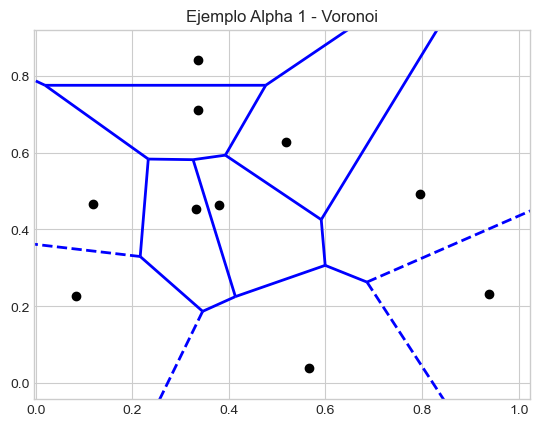

Calculando Filtración Alpha...
Calculando Persistencia...


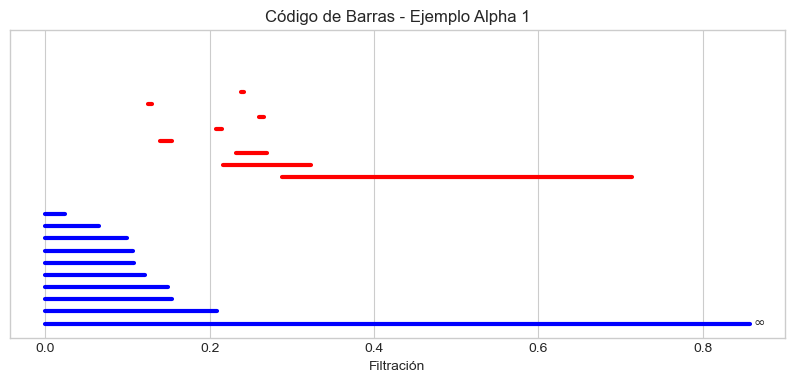

Primeros 10 umbrales de filtración: [0.0, 0.024594630110749274, 0.06491550663246884, 0.09964158316325628, 0.1067160499498478, 0.10755922964315728, 0.12139746602831021, 0.12497889333174499, 0.12897443080262758, 0.1292619191823917]

=== Ejemplo Alpha 2 ===
Generando Diagrama de Voronoi...


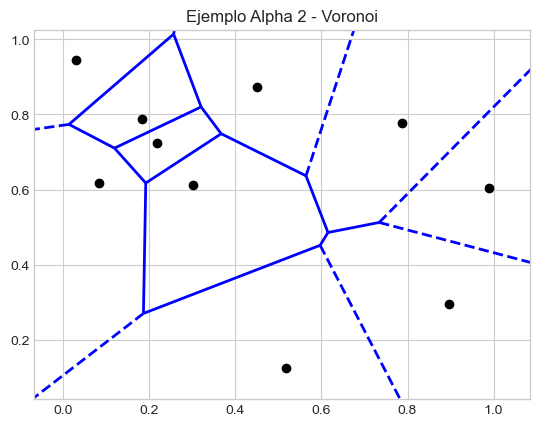

Calculando Filtración Alpha...
Calculando Persistencia...


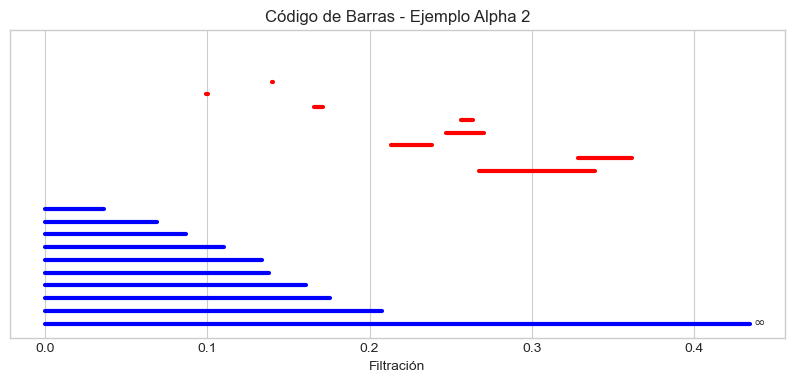

Primeros 10 umbrales de filtración: [0.0, 0.036163698601824126, 0.0687469369692617, 0.08658875829741432, 0.09914415136786997, 0.1004969808973943, 0.10945407826835805, 0.10947698997829008, 0.11055084225965854, 0.1334764201653083]

=== Ejemplo Alpha 3 ===
Generando Diagrama de Voronoi...


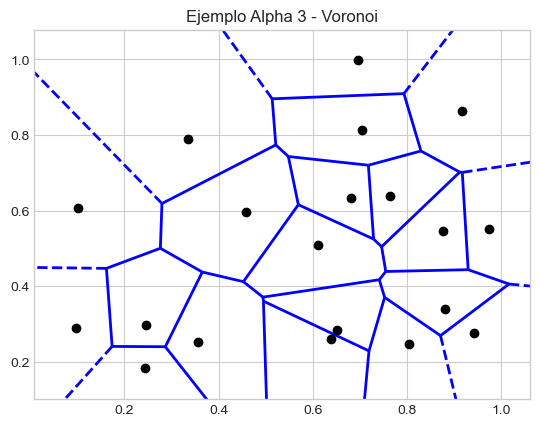

Calculando Filtración Alpha...
Calculando Persistencia...


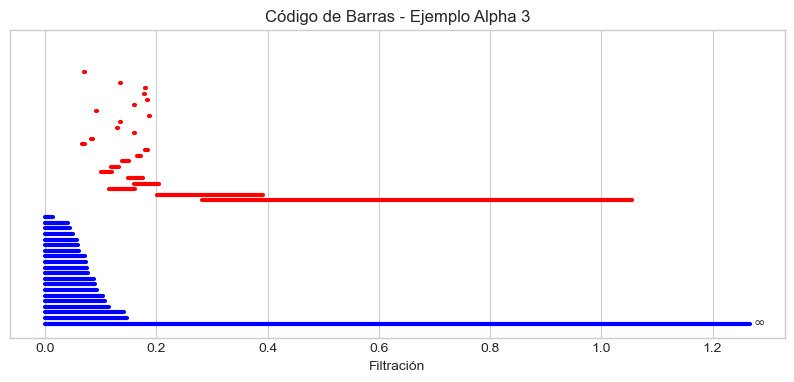

Primeros 10 umbrales de filtración: [0.0, 0.013372492334073723, 0.04142029475612175, 0.04400202037538318, 0.04911456088486795, 0.05750211401213061, 0.05979415174994811, 0.059877821276734536, 0.06629715679818932, 0.07025569794627363]

=== Ejemplo 4: Círculo Ruidoso ===
Generando Diagrama de Voronoi...


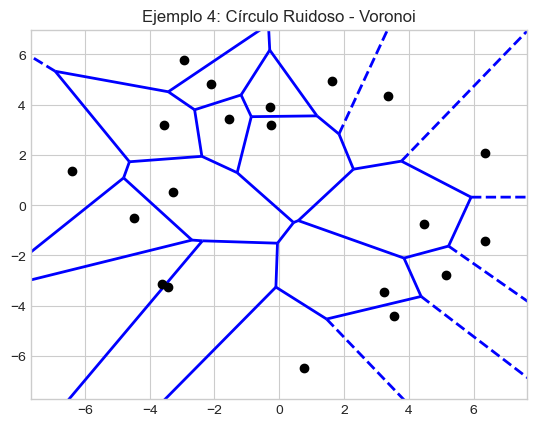

Calculando Filtración Alpha...
Calculando Persistencia...


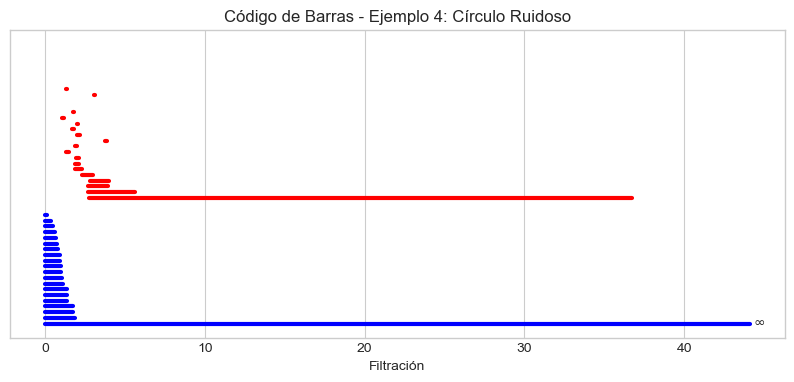

Primeros 10 umbrales de filtración: [0.0, 0.10565789180691255, 0.3594476020513678, 0.512709492652287, 0.6337392347297187, 0.6579110269255046, 0.6811155450226897, 0.6962666627950436, 0.7473705160649131, 0.7725554426347773]


In [24]:
# ==============================================================================
# PARTE 2: REPLICACIÓN DE EJEMPLOS DEL PDF "EJEMPLOS ALPHA Y VR"
# ==============================================================================

def analyze_point_cloud(points, title="Análisis de Nube de Puntos"):
    print(f"\n=== {title} ===")
    
    # 1. Visualizar Puntos y Voronoi
    print("Generando Diagrama de Voronoi...")
    vor = Voronoi(points)
    fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, line_colors='blue')
    plt.plot(points[:, 0], points[:, 1], 'ko')
    plt.title(f"{title} - Voronoi")
    plt.show()
    
    # 2. Filtración Alpha
    print("Calculando Filtración Alpha...")
    sc_alpha = alpha_complex_filtration(points)
    
    # 3. Diagrama de Persistencia
    print("Calculando Persistencia...")
    diag = compute_persistence_matrix(sc_alpha)
    plot_barcode(diag, title=f"Código de Barras - {title}")
    
    # 4. Umbrales críticos (solo los primeros 10 para no saturar)
    thresholds = sc_alpha.threshold()
    print(f"Primeros 10 umbrales de filtración: {thresholds[:10]}")

# ---------------------------------------------------------
# Ejemplo Alpha 1: 10 puntos aleatorios (Coordenadas extraídas del PDF)
# ---------------------------------------------------------
points1 = np.array([
    (0.38021546727456423, 0.46419202339598786), 
    (0.7951628297672293, 0.49263630135869474), 
    (0.566623772375203, 0.038325621649018426), # Corregido signo negativo OCR
    (0.3369306814864865, 0.7103735061134965), 
    (0.08272837815822842, 0.2263273314352896), 
    (0.5180166301873989, 0.6271769943824689), 
    (0.33691411899985035, 0.8402045183219995), 
    (0.33244488399729255, 0.4524636520475205), 
    (0.11778991601260325, 0.46657734204021165), 
    (0.9384303415747769, 0.2313873874340855)
])
analyze_point_cloud(points1, "Ejemplo Alpha 1")

# ---------------------------------------------------------
# Ejemplo Alpha 2: Otra nube de 10 puntos
# ---------------------------------------------------------
points2 = np.array([
    [0.8957641450573793, 0.2950833519989374],
    [0.028621391963087994, 0.9440875759025237],
    [0.517621505875702, 0.1236620161847416],
    [0.7871047164191424, 0.7777474116014623],
    [0.21869796914805273, 0.7233589914276723],
    [0.9891035292480995, 0.6032186214942837],
    [0.30113764052453484, 0.613321425324272],
    [0.18407448222466916, 0.7868606964403773],
    [0.4496777667376678, 0.874366215574117],
    [0.08225571534539433, 0.616710205071694]
])
analyze_point_cloud(points2, "Ejemplo Alpha 2")

# ---------------------------------------------------------
# Ejemplo Alpha 3: Nube más densa (aprox 20 puntos)
# ---------------------------------------------------------
points3 = np.array([
    (0.8753299639906736, 0.5452963206013219),
    (0.915335120559448, 0.8622822047328554),
    (0.9411759819184322, 0.2748278885761678),
    (0.7052034033196758, 0.8122389578499669),
    (0.973443158329487, 0.5500672178217452),
    (0.101349658961157, 0.6072126518098413),
    (0.6099428935549683, 0.5095146187792166),
    (0.6810379648990679, 0.6343196355745316),
    (0.763747595111296, 0.6389758508715849),
    (0.6521290891236327, 0.28340359060768416),
    (0.4569706839687516, 0.5970966728571825),
    (0.3339042514617916, 0.7888181435443109),
    (0.24447615661103717, 0.18247811626397858),
    (0.6961254832425103, 0.9974914431850389),
    (0.2452860638322797, 0.2974794924024807),
    (0.09631846692736679, 0.2887656085651358),
    (0.638575556222527, 0.26034722595932536),
    (0.803241921795395, 0.24803894619975986),
    (0.8809182300057703, 0.3389661339754195),
    (0.3565859265456749, 0.25327819736066515)
])
analyze_point_cloud(points3, "Ejemplo Alpha 3")

# ---------------------------------------------------------
# Ejemplo 4: Círculo con ruido (Coordenadas extraídas del PDF)
# ---------------------------------------------------------
circle_points = np.array([
    [0.7649936, -6.49105706],
    [-0.26047978, 3.17414802],
    [5.16486466, -2.77709227],
    [6.3630621, 2.08442442],
    [1.63681198, 4.95671697],
    [-4.47103343, -0.4944843],
    [-2.12035066, 4.80887876],
    [-3.44986384, -3.25828704],
    [-3.55428879, 3.18415674],
    [-0.27202076, 3.89295058],
    [-2.9512385, 5.76602403],
    [6.36747098, -1.44195299],
    [3.36400365, 4.33230353],
    [3.23972602, -3.44494391],
    [-3.29551494, 0.50827386],
    [-1.55188576, 3.42645393],
    [-3.62672644, -3.14264111],
    [3.54177077, -4.42486894],
    [-6.39734363, 1.37489294],
    [4.46578318, -0.76225718]
])
analyze_point_cloud(circle_points, "Ejemplo 4: Círculo Ruidoso")